# Primerjava pristopov za luščenje ključnih besed na anotiranih besedilih iz revije Elektrotehniški vestnik

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz besedil iz revije Elektrotehniški vestnik, ki imajo označene ključne besede. Ključne besede so označene s strani avtorjev člankov.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede z ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [1]:
import string
import ast

import nltk
from textsemantics.server_api import ServerAPI
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_SLOVENE
from matplotlib import pyplot as plt
import yake
from gensim.summarization import keywords as gensim_kw
import rake

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)

Naložimo metapodatke in dokumente iz zbirke _elektrotehniski-vestnik-clanki_ - članki objavljeni v reviji Elektrotehniški vestnik. Dokumente preprocesiramo in izluščimo posamezne besede.

In [2]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_SLOVENE)

def preprocess(corpus):
    stop_words = set(stopwords.words('slovene'))
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

api = ServerAPI()
metadata = api.get_metadata('elektrotehniski-vestnik-clanki')
metadata["texts"] = api.get_texts(urls=metadata['Text file'])
# stolpec s ključnimi besedami vsebuje seznam zapisan kot niz - pretovri v seznam
metadata["Keywords"] = metadata["Keywords"].apply(ast.literal_eval)
# pretvorba ključnih besed v posamezne besede in lematizacija
metadata["Keywords_one_word"] = metadata["Keywords"].apply(
    lambda ph: [lemmatizer.lemmatize(w) for p in ph for w in p.split()]
)
# izpusti en članek brez ključnih besed
metadata = metadata[metadata["Keywords_one_word"].str.len() != 0]

full_texts = metadata["Abstract"] + "\n" + metadata["texts"]
tokens_list = preprocess(full_texts)

print(f"Število dokumentov: {len(metadata)}")

Število dokumentov: 386


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [3]:
metadata.head()

,Title,Abstract,Keywords,URL,Text file,texts,Keywords_one_word
0,Uporaba komercialnega sledilnika točki maksima...,"Pri letalniku, ki uporablja baterije kot prima...","[brezpilotni letalnik, sledilnik točki maksima...",https://ev.fe.uni-lj.si/1-2-2020/Hrovatin.pdf,http://file.biolab.si/text-semantics/data/elek...,1 UVOD\nBrezpilotni letalniki se danes nepogre...,"[brezpiloten, letalnik, sledilnik, točka, maks..."
1,SIZiF - i-sistem izpitov na Zdravstveni fakult...,SIZiF je informacijsko-tehnološko podprt siste...,"[pisni preizkusi znanja, optična razpoznava, o...",https://ev.fe.uni-lj.si/1-2-2020/Fosnaric.pdf,http://file.biolab.si/text-semantics/data/elek...,1 UVOD\nFinančna podhranjenost našega visokega...,"[pisen, preizkus, znanje, optičen, razpoznavat..."
2,Uspešnost regulative pri vzpostavitvi in delov...,Marca 2011 je začela delovati agencija Agency ...,"[ACER, regulator, trgovec, notranji trg z ener...",https://ev.fe.uni-lj.si/1-2-2020/Klopcic.pdf,http://file.biolab.si/text-semantics/data/elek...,1 UVOD\nPrestrukturiranje elektroenergetike v ...,"[ACER, regulator, trgovec, notranji, trg, z, e..."
3,Optični komunikacijski poskusi za interaktivno...,"Optične komunikacije, zasnovane na optičnem vl...","[optične komunikacije, optično vlakno, interak...",https://ev.fe.uni-lj.si/1-2-2020/Baliz.pdf,http://file.biolab.si/text-semantics/data/elek...,1 UVOD\nOptične komunikacijske tehnologije so ...,"[optičen, komunikacija, optičen, vlakno, inter..."
4,Uporaba metode absolutnih vozliščnih koordinat...,Umestitev v prostor je eden izmed ključnih izz...,"[daljnovod, žledenje, absolutne vozliščne koor...",https://ev.fe.uni-lj.si/1-2-2020/Zemljaric.pdf,http://file.biolab.si/text-semantics/data/elek...,1 UVOD\nGraditev prenosnih elektroenergetskih ...,"[daljnovod, žledenje, absoluten, vozliščen, ko..."


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metodi z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) 1) upoštevajoč vse besede v korpusu, 2) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [4]:
%%time 
tfidf_keywords = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

CPU times: user 6.88 s, sys: 62.5 ms, total: 6.94 s
Wall time: 7.09 s


In [5]:
%%time
emb_corp_keywords = specific_words.embedding_corpus_keywords(tokens=tokens_list)
emb_corp_keywords = [[x for x, _ in wds] for wds in emb_corp_keywords]

CPU times: user 8min 52s, sys: 8.67 s, total: 9min 1s
Wall time: 10min


In [6]:
%%time 
emb_doc_keywords = specific_words.embedding_document_keywords(tokens=tokens_list)
emb_doc_keywords = [[x for x, _ in wds] for wds in emb_doc_keywords]

CPU times: user 49.1 s, sys: 2.02 s, total: 51.1 s
Wall time: 57.3 s


In [7]:
%%time 
stop_path = "utils/slovenian-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=1)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [lemmatizer.lemmatize(x) for x, _ in kw]

rake_keywords = [rake_method(txt) for txt in full_texts]

CPU times: user 1min 56s, sys: 753 ms, total: 1min 56s
Wall time: 2min 3s


In [8]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="sl", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in full_texts]

CPU times: user 1min 54s, sys: 3.1 s, total: 1min 57s
Wall time: 2min 13s


In [9]:
%%time
def text_rank(tokens):
    kw = gensim_kw(" ".join(tokens), words=20, scores=True)
    return [x for w, _ in kw for x in w.split()]

text_rank_keywords = [text_rank(tokens) for tokens in tokens_list]

CPU times: user 1min 34s, sys: 10.4 s, total: 1min 45s
Wall time: 50.1 s


In [10]:
methods = [
    ("Emb - korpus", emb_corp_keywords),
    ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [11]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

Emb - korpus - Povprečno število besed: 41862.0 Minimalno število specifičnih besed: 41862
Emb - document - Povprečno število besed: 676.0 Minimalno število specifičnih besed: 196
TFIDF - Povprečno število besed: 675.5 Minimalno število specifičnih besed: 196
RAKE - Povprečno število besed: 384.0 Minimalno število specifičnih besed: 110
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 20
TextRank - Povprečno število besed: 20.5 Minimalno število specifičnih besed: 20


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [12]:
kw = metadata['Keywords_one_word']
precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

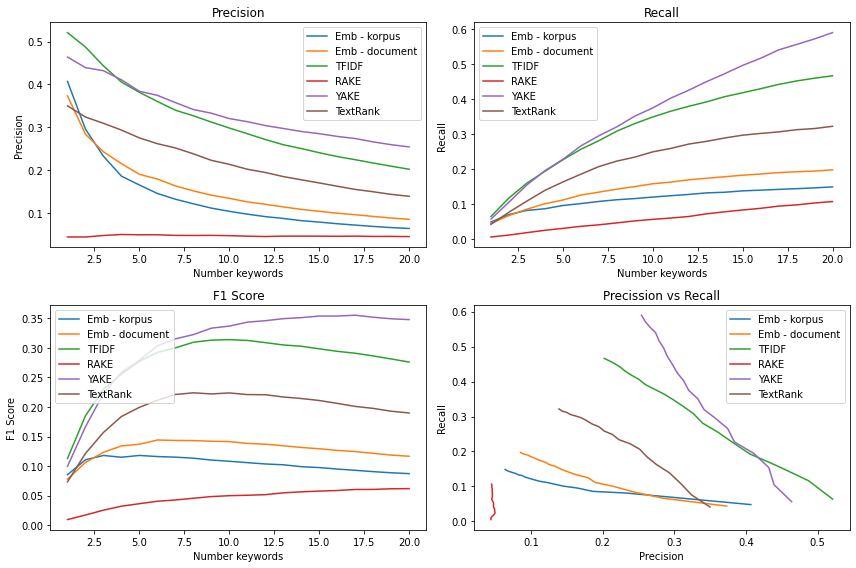

In [13]:
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
for i, (title, sc) in enumerate(scores):
    plt.subplot(2, 2, i + 1)
    for p, (l, _) in zip(sc, methods):
        plt.plot(range(1, 21), p, label=l)
    plt.legend()
    plt.title(title)
    plt.xlabel("Number keywords")
    plt.ylabel(title)
        
plt.subplot(2, 2, 4)
for p, r, (l, _) in zip(precisions, recalls, methods):
    plt.plot(p, r, label=l)
    plt.legend()
    plt.title("Precission vs Recall")
    plt.xlabel("Precision")
    plt.ylabel("Recall")

plt.tight_layout()

Iz grafov lahko sklepamo, da se na primeru člankov iz revije Elektrotehniški vestnik najbolje obneseta metodi TF-IDF in YAKE!. Sledi TextRank. Podobno se obneseta metodi z vložitvami, najslabše pa se obnese metoda RAKE.